In [2]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt
bempp.api.show_available_platforms_and_devices()
bempp.api.set_default_device(0, 0)

0: Portable Computing Language
    0: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz


Setting the size of the element of the mesh and the center of the two spheres. The radius of the sphere is 1 and the length of the cube is 1 by default.

In [85]:
h = 0.2  # size of the mesh (element)
center1 = (3, 0, 0) # center of one sphere
center2 = (-3, 0, 0)
sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
sphere2 =  bempp.api.shapes.sphere(h=h, origin=center2)

Construct RWG and SNC in difference spaces.

In [86]:
rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

snc1 = bempp.api.function_space(sphere1, "SNC", 0)
snc2 = bempp.api.function_space(sphere2, "SNC", 0)

In [87]:
wavenumber = 1j * 0.05

op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

mat11 = op11.weak_form().A
mat12 = op12.weak_form().A
mat21 = op21.weak_form().A
mat22 = op22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.real(np.block([[mat11,mat12],[mat21,mat22]]))    
mat2 = np.real(np.block([[mat11,mat12_zero],[mat21_zero,mat22]]))
combined = np.linalg.inv(mat2).dot(mat)
sign, logdet = slogdet(combined)
print(logdet)

-0.0001813685212522184


In [88]:
from bempp.api.utils import Octree
box = sphere1.bounding_box
vertices = np.empty((3,rwg1.global_dof_count),np.float64)
for index in range(rwg1.global_dof_count):
    elem,local_id = rwg1.global2local[index][0]
    edge_id = sphere1.element_edges[local_id,elem]
    vertices[:,index] = .5*(sphere1.vertices[:,sphere1.edges[0,edge_id]] + sphere1.vertices[:,sphere1.edges[0,edge_id]])
tree = Octree(box[:,0],box[:,1], 2,vertices)

In [89]:
sorted_indices = tree.sorted_indices

In [90]:
sorted_mat11 = mat11[:, sorted_indices][sorted_indices, :]
sorted_mat12 = mat12[:, sorted_indices][sorted_indices, :]

In [93]:
box2 = sphere2.bounding_box
vertices2 = np.empty((3,rwg2.global_dof_count),np.float64)
for index in range(rwg2.global_dof_count):
    elem,local_id = rwg2.global2local[index][0]
    edge_id = sphere2.element_edges[local_id,elem]
    vertices2[:,index] = .5*(sphere2.vertices[:,sphere2.edges[0,edge_id]] + sphere2.vertices[:,sphere2.edges[0,edge_id]])
tree2 = Octree(box[:,0],box[:,1], 2,vertices2)

In [94]:
sorted_indices2 = tree2.sorted_indices

In [124]:
sorted_mat22 = mat22[:, sorted_indices2][sorted_indices2, :]
sorted_mat21 = mat21[:, sorted_indices2][sorted_indices2, :]

In [129]:
sorted_mat = np.real(np.block([[sorted_mat11,sorted_mat12],[sorted_mat21,sorted_mat22]]))    
sorted_mat2 = np.real(np.block([[sorted_mat11,mat12_zero],[mat21_zero,sorted_mat22]]))
sorted_combined = np.linalg.inv(sorted_mat2).dot(sorted_mat)
sign2, logdet2 = slogdet(sorted_combined)
print(logdet2)

7.14559011053717e-07


In [126]:
def get_box(nx, ny, sorted_mat, nboxes, n):
    """Return the content of a given box"""
    size = n//nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return sorted_mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [127]:
def plot_box_ranks(A, nboxes, n, tol=1E-11):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Blues')
    clb = plt.colorbar()
    clb.ax.set_title('Rank')

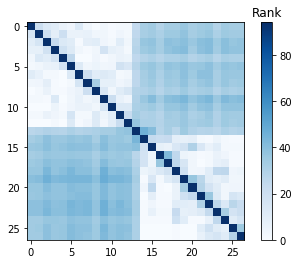

In [128]:
plot_box_ranks(sorted_combined,nboxes =27, n= sorted_combined.shape[0])